# This notebook provides the functionality to build, train, and test a CNN for predicting mosquito age, grouped age, species, and status.

## Structure:
* Import packages to be used.
* Load mosquito data.
* Define fucntions for plotting, visualisation, and logging.
* Define a function to build the CNN.
* Define a function to train the CNN.
* Main section to organise data, define the CNN, and call the building and training of the CNN.


In [1]:
import pylab as pl
import datetime
import pandas as pd
import itertools
from itertools import cycle
import pickle
import random as rn
import os
from time import time
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

font = {'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils import resample

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

Using TensorFlow backend.


In [2]:
# rand_seed = np.random.randint(low=0, high=100)
rand_seed = 16
print(rand_seed)

16


In [3]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(rand_seed)

## The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
# session_conf = tf.ConfigProto(device_count = {'GPU':0}, intra_op_parallelism_threads=4) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# session_conf = tf.ConfigProto(device_count = {'GPU':0}) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.5
## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)

sess = tf.Session(graph=tf.get_default_graph(), config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

## Load the data

The data file is created using Loco Mosquito:
https://github.com/magonji/MIMI-project/blob/master/Loco%20mosquito%204.0.ipynb

### The data file has headings: Species - Status - RearCnd - Age - Country- Frequencies

### Moved to each model run section

## Function used to create a new folder for the CNN outputs.
Useful to stop forgetting to name a new folder when trying out a new model varient and overwriting a days training.

In [4]:
def build_folder(fold, to_build = False):
    if not os.path.isdir(fold):
        if to_build == True:
            os.mkdir(fold)
        else:
            print('Directory does not exists, not creating directory!')
    else:
        if to_build == True:
            raise NameError('Directory already exists, cannot be created!')

## Function for plotting confusion matrcies
This normalizes the confusion matrix and ensures neat plotting for all outputs.

In [5]:
def plot_confusion_matrix(cm, classes, output, save_path, model_name, fold,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          printout=False):

    font = {'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if printout:
            print("Normalized confusion matrix")
    else:
        if printout:
            print('Confusion matrix, without normalization')

    if printout:
        print(cm)
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1) # np.max(np.sum(cm, axis=1)))
#     plt.title([title+' - '+model_name])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=2)
#     plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig((save_path+"Confusion_Matrix_"+model_name+"_"+fold+"_"+output[1:]+".png"))
    plt.close()

## Function used for visualizing outputs
This splits the output data into the four categories before plotting the confusion matricies.

In [6]:
## for visualizing losses and metrics once the neural network fold is trained
def visualize(histories, save_path, model_name, fold, classes, outputs, predicted, true):
    # Sort out predictions and true labels
    for label_predictions_arr, label_true_arr, classes, outputs in zip(predicted, true, classes, outputs):
        classes_pred = np.argmax(label_predictions_arr, axis=-1)
        classes_true = np.argmax(label_true_arr, axis=-1)
        cnf_matrix = confusion_matrix(classes_true, classes_pred)
        plot_confusion_matrix(cnf_matrix, classes, outputs, save_path, model_name, fold)

## Data logging

In [7]:
## for logging data associated with the model
def log_data(log, name, fold, save_path):
    f = open((save_path+name+'_'+str(fold)+'_log.txt'), 'w')
    np.savetxt(f, log)
    f.close()

## Fucntion for graphing the training data
This fucntion creates tidy graphs of loss and accuracy as the models are training.

In [8]:
def graph_history(history, model_name, model_ver_num, fold, save_path):

    font = {'weight' : 'normal',
            'size'   : 18}

    matplotlib.rc('font', **font)
    
    #not_validation = list(filter(lambda x: x[0:3] != "val", history.history.keys()))
#     print('history.history.keys : {}'.format(history.history.keys()))
    filtered = filter(lambda x: x[0:3] != "val", history.history.keys())
    not_validation = list(filtered)
    for i in not_validation:
        plt.figure(figsize=(15,7))
#         plt.title(i+"/ "+"val_"+i)
        plt.plot(history.history[i], label=i)
        plt.plot(history.history["val_"+i], label="val_"+i)
        plt.legend()
        plt.xlabel("epoch")
        plt.ylabel(i)
        plt.savefig(save_path +model_name+"_"+str(model_ver_num)+"_"+str(fold)+"_"+i)
        plt.close()

## funciton to create the CNN
This function takes as an input a list of dictionaries. Each element in the list is a new hidden layer in the model. For each layer the dictionary defines the layer to be used.

### Available options are:
Convolutional Layer:
* type = 'c'
* filter = optional number of filters
* kernel = optional size of the filters
* stride = optional size of stride to take between filters
* pooling = optional width of the max pooling
* {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2}

dense layer:
* type = 'd'
* width = option width of the layer
* {'type':'d', 'width':500}

In [9]:
def create_models(model_shape, input_layer_dim, SelectFreqs):

    regConst = 0.02
    sgd = keras.optimizers.SGD(lr=0.003, decay=1e-5, momentum=0.9, nesterov=True, clipnorm=1.)
    cce = 'categorical_crossentropy'

    if SelectFreqs:
        input_vec = Input(name='input', shape=(input_layer_dim,))
        xd = Dense(name='d1', units=500, activation='relu', 
                     kernel_regularizer=l2(regConst), 
                     kernel_initializer='he_normal')(input_vec)
        xd = BatchNormalization(name='batchnorm_1')(xd)
        
    else:
        input_vec = Input(name='input', shape=(input_layer_dim,1))
        
        for i, layerwidth in zip(range(len(model_shape)),model_shape):
            if i == 0:
                if model_shape[i]['type'] == 'c':
                    xd = Conv1D(name=('Conv'+str(i+1)), filters=model_shape[i]['filter'], 
                     kernel_size = model_shape[i]['kernel'], strides = model_shape[i]['stride'],
                     activation = 'relu',
                     kernel_regularizer=l2(regConst), 
                     kernel_initializer='he_normal')(input_vec)
                    xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd)
                    xd = MaxPooling1D(pool_size=(model_shape[i]['pooling']))(xd)

                elif model_shape[i]['type'] == 'd':
                    xd = Dense(name=('d'+str(i+1)), units=model_shape[i]['width'], activation='relu', 
                     kernel_regularizer=l2(regConst), 
                     kernel_initializer='he_normal')(input_vec)
                    xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd) 
                    xd = Dropout(name=('dout'+str(i+1)), rate=0.5)(xd) 

            else:
                if model_shape[i]['type'] == 'c':
                    xd = Conv1D(name=('Conv'+str(i+1)), filters=model_shape[i]['filter'], 
                     kernel_size = model_shape[i]['kernel'], strides = model_shape[i]['stride'],
                     activation = 'relu',
                     kernel_regularizer=l2(regConst), 
                     kernel_initializer='he_normal')(xd)
                    xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd)
                    xd = MaxPooling1D(pool_size=(model_shape[i]['pooling']))(xd)

                elif model_shape[i]['type'] == 'd':
                    if model_shape[i-1]['type'] == 'c':
                        xd = Flatten()(xd)

                    xd = Dropout(name=('dout'+str(i+1)), rate=0.5)(xd)
                    xd = Dense(name=('d'+str(i+1)), units=model_shape[i]['width'], activation='relu', 
                     kernel_regularizer=l2(regConst), 
                     kernel_initializer='he_normal')(xd)
                    xd = BatchNormalization(name=('batchnorm_'+str(i+1)))(xd) 
        
    
#     xAge     = Dense(name = 'age', units = 17, 
#                      activation = 'softmax', 
#                      kernel_regularizer = l2(regConst), 
#                      kernel_initializer = 'he_normal')(xd)
    xAgeGroup     = Dense(name = 'age_group', units = 3, 
                     activation = 'softmax', 
                     kernel_regularizer = l2(regConst), 
                     kernel_initializer = 'he_normal')(xd)
    xSpecies = Dense(name ='species', units = 3, 
                     activation = 'softmax', 
                     kernel_regularizer = l2(regConst), 
                     kernel_initializer = 'he_normal')(xd)

    outputs = []
#     for i in ['xAge', 'xAgeGroup', 'xSpecies']:
    for i in ['xAgeGroup', 'xSpecies']:
        outputs.append(locals()[i])
    model = Model(inputs = input_vec, outputs = outputs)
    
    model.compile(loss=cce, metrics=['acc'], 
                  optimizer=sgd)
#     model.summary()
    return model

## Function to train the model

This function will split the data into training and validation and call the create models function. This fucntion returns the model and training history.

In [21]:
def train_models(model_to_test, save_path, SelectFreqs=False):
    
    out_path = save_path+'out/'
    build_folder(out_path, True)

    model_shape = model_to_test["model_shape"][0]
    model_name = model_to_test["model_name"][0]
#     input_layer_dim = model_to_test["input_layer_dim"][0]
    model_ver_num = model_to_test["model_ver_num"][0]
    fold = model_to_test["fold"][0]
    label = model_to_test["labels"][0]
    features = model_to_test["features"][0]
    classes = model_to_test["classes"][0]
    outputs = model_to_test["outputs"][0]
    compile_loss = model_to_test["compile_loss"][0]
    compile_metrics = model_to_test["compile_metrics"][0]

#     ## Split into training / testing
#     test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
#     ## Pack up data
#     X_train = test_splits.pop(0)
#     X_val = test_splits.pop(0)
#     y_train = test_splits[::2]
#     y_val = test_splits[1::2]
    
#     out_model = create_models(model_shape, input_layer_dim, SelectFreqs)
#     out_model.summary()
#     out_history = out_model.fit(x = X_train, 
#                             y = y_train,
#                             batch_size = 128*16, 
#                             verbose = 0, 
#                             epochs = 8000,
#                             validation_data = (X_val, y_val),
#                             callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                         patience=400, verbose=0, mode='auto'), 
#                                         CSVLogger(save_path+model_name+"_"+str(model_ver_num)+'.csv', append=True, separator=';')])
#     scores = out_model.evaluate(X_val, y_val)
#     print(out_model.metrics_names)

    ## Kfold training
    seed = rand_seed
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    ## Split data into test and train
    
    model_ver_num = 0
    cv_scores = []
    best_score = 0
    for train_index, val_index in kfold.split(features):
        print('Fold {} Running'.format(model_ver_num))
        
        X_train, X_val = features[train_index], features[val_index]
        y_train, y_val = list(map(lambda y:y[train_index], label)), list(map(lambda y:y[val_index], label))

        model = create_models(model_shape, input_layer_dim, SelectFreqs)
        if model_ver_num == 0:
            model.summary()

        history = model.fit(x = X_train, 
                            y = y_train,
                            batch_size = 128*16, 
                            verbose = 0, 
                            epochs = 8000,
                            validation_data = (X_val, y_val),
                            callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        patience=400, verbose=0, mode='auto'), 
                                        CSVLogger(out_path+model_name+"_"+str(model_ver_num)+'.csv', append=True, separator=';')])
        scores = model.evaluate(X_val, y_val)
        model.save((out_path+model_name+"_"+str(model_ver_num)+'_Model.h5'))
        graph_history(history, model_name, model_ver_num, 0, out_path)
#         print(model.metrics_names)
#         print(scores)
        if (scores[3] + scores[4]) > best_score:
            out_model = model
            out_history = history
        
        model_ver_num += 1
        
#         # Clear the Keras session, otherwise it will keep adding new
#         # models to the same TensorFlow graph each time we create
#         # a model with a different set of hyper-parameters.
#         K.clear_session()

#         # Delete the Keras model with these hyper-parameters from memory.
#         del model
        
    out_model.save((save_path+'Best_Model.h5'))
    graph_history(out_history, 'Best_Model', 0, 0, save_path)
    
    return out_model, out_history

## Main section

Functionality:
* Oganises the data into a format of lists of data, classes, labels.
* Define the CNN to be built.
* Define the KFold validation to be used.
* Build a folder to output data into.
* Standardize and oragnise data into training/testing.
* Call the model training.
* Organize outputs and call visualization for plotting and graphing.


## No Bobo

In [27]:
SelectFreqs = False

df = pd.read_csv("/home/josh/Documents/Mosquito_Project/MIMI-Analysis/Data/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

df_vf = df[df['RearCnd']=='VF']
df_vf = df_vf[df_vf['Status']=='UN']
df = df[df['RearCnd']!='VF']
df = df[df['Status']!='UN']
df_l = df[df['RearCnd']=='TL']
df_l_g = df_l[df_l['Country']=='S']
df_l_g_a = df_l_g[df_l_g['Species']=='AA']
age_counts = df_l_g_a.groupby('AgeGroup').size()
print('df_l_g_a : {}'.format(age_counts))
df_l_g_g = df_l_g[df_l_g['Species']=='AG']
age_counts = df_l_g_g.groupby('AgeGroup').size()
print('df_l_g_g : {}'.format(age_counts))
df_l_g_c = df_l_g[df_l_g['Species']=='AC']
age_counts = df_l_g_c.groupby('AgeGroup').size()
print('df_l_g_c : {}'.format(age_counts))
df_l_t = df_l[df_l['Country']=='T']
df_l_t_a = df_l_t[df_l_t['Species']=='AA']
age_counts = df_l_t_a.groupby('AgeGroup').size()
print('df_l_t_a : {}'.format(age_counts))
df_l_t_g = df_l_t[df_l_t['Species']=='AG']
age_counts = df_l_t_g.groupby('AgeGroup').size()
print('df_l_t_g : {}'.format(age_counts))
df_l_b = df_l[df_l['Country']=='B']
df_l_b_g = df_l_b[df_l_b['Species']=='AG']
age_counts = df_l_b_g.groupby('AgeGroup').size()
print('df_l_b_g : {}'.format(age_counts))
df_l_b_c = df_l_b[df_l_b['Species']=='AC']
age_counts = df_l_b_c.groupby('AgeGroup').size()
print('df_l_b_c : {}'.format(age_counts))
df_f = df[df['RearCnd']=='TF']
df_f_t = df_f[df_f['Country']=='T']
df_f_t_a = df_f_t[df_f_t['Species']=='AA']
age_counts = df_f_t_a.groupby('AgeGroup').size()
print('df_f_t_a : {}'.format(age_counts))
# df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
df_f_b = df_f[df_f['Country']=='B']
df_f_b_g = df_f_b[df_f_b['Species']=='AG']
age_counts = df_f_b_g.groupby('AgeGroup').size()
print('df_f_b_g : {}'.format(age_counts))
df_f_b_c = df_f_b[df_f_b['Species']=='AC']
age_counts = df_f_b_c.groupby('AgeGroup').size()
print('df_f_b_c : {}'.format(age_counts))
df_vf_t = df_vf[df_vf['Country']=='T']
df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
age_counts = df_vf_t_a.groupby('AgeGroup').size()
print('df_vf_t_a : {}'.format(age_counts))
df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
age_counts = df_vf_t_g.groupby('AgeGroup').size()
print('df_vf_t_g : {}'.format(age_counts))
df_vf_b = df_vf[df_vf['Country']=='B']
df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
age_counts = df_vf_b_g.groupby('AgeGroup').size()
print('df_vf_b_g : {}'.format(age_counts))
df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
age_counts = df_vf_b_c.groupby('AgeGroup').size()
print('df_vf_b_c : {}'.format(age_counts))
Species_counts = df_l_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_l_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_b.groupby('Species').size()
print('{}'.format(Species_counts))

size_inc = 400
for age in range(3):
    df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_train = df_temp.iloc[index_df_temp_inc]
#         df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
#         df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_g_a[df_l_g_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_g[df_l_g_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_c[df_l_g_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0 # 50
# for age in range(3):
#     df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0
# for age in range(3):
#     df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0
# for age in range(3):
#     df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
    
    
Species_counts = df_train.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_train.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_train.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_train.groupby('AgeGroup').size()
print('{}'.format(age_counts))
Species_counts = df_test.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_test.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_test.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_test.groupby('AgeGroup').size()
print('{}'.format(age_counts))


if SelectFreqs:
    X = df_train[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X = df_train.iloc[:,6:-1]
y_age = df_train["Age"]
y_age_groups = df_train["AgeGroup"]
y_species = df_train["Species"]
y_status = df_train["Status"]

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))

X = np.asarray(X)[:, :-1]
y_age = np.asarray(y_age)
y_age_groups = np.asarray(y_age_groups)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)

if SelectFreqs:
    X_vf = df_test[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X_vf = df_test.iloc[:,6:-1]
y_age_vf = df_test["Age"]
y_age_groups_vf = df_test["AgeGroup"]
y_species_vf = df_test["Species"]
y_status_vf = df_test["Status"]
print('shape of X_vf : {}'.format(X_vf.shape))
print('shape of y_age_vf age : {}'.format(y_age_vf.shape))
print('shape of y_age_groups_vf : {}'.format(y_age_groups_vf.shape))
print('shape of y y_species_vf : {}'.format(y_species_vf.shape))
print('shape of y y_status_vf : {}'.format(y_status_vf.shape))
X_vf = np.asarray(X_vf)[:,:-1]
y_age_vf = np.asarray(y_age_vf)
y_age_groups_vf = np.asarray(y_age_groups_vf)
y_species_vf = np.asarray(y_species_vf)
y_status_vf = np.asarray(y_status_vf)



RearCnd
TF     9618
TL    27838
VF     3285
dtype: int64
df_l_g_a : AgeGroup
0    306
1    592
2    763
dtype: int64
df_l_g_g : AgeGroup
0    629
1    827
2    821
dtype: int64
df_l_g_c : AgeGroup
0     318
1     892
2    1282
dtype: int64
df_l_t_a : AgeGroup
0     708
1    3474
2    4375
dtype: int64
df_l_t_g : AgeGroup
0     726
1    3390
2    4488
dtype: int64
df_l_b_g : AgeGroup
0    481
1    666
2    858
dtype: int64
df_l_b_c : AgeGroup
0    514
1    777
2    937
dtype: int64
df_f_t_a : AgeGroup
0     668
1    2316
2    2703
dtype: int64
df_f_b_g : AgeGroup
0     831
1    1003
2    1070
dtype: int64
df_f_b_c : AgeGroup
0    458
2    569
dtype: int64
df_vf_t_a : AgeGroup
0    207
1    627
2    512
dtype: int64
df_vf_t_g : AgeGroup
0    209
1    584
2    625
dtype: int64
df_vf_b_g : AgeGroup
0    113
1    104
2     48
dtype: int64
df_vf_b_c : AgeGroup
0    119
1    109
2     20
dtype: int64
Species
AA    8557
AG    8604
dtype: int64
Species
AC    2228
AG    2005
dtype: int64
Species

In [28]:
input_layer_dim = len(X[0])

## Train
y_age_groups_list = [[age] for age in y_age_groups]
y_species_list = [[species] for species in y_species]

## Test
y_age_groups_list_test = [[age] for age in y_age_groups_vf]
y_species_list_test = [[species] for species in y_species_vf]

age_mlb = MultiLabelBinarizer().fit(np.vstack((np.array(y_age_groups_list),np.array(y_age_groups_list_test))))
age_groups = age_mlb.transform(np.array(y_age_groups_list))
age_groups_test = age_mlb.transform(np.array(y_age_groups_list_test))

species_mlb = MultiLabelBinarizer().fit(np.vstack((np.array(y_species_list),np.array(y_species_list_test))))
species = species_mlb.transform(np.array(y_species_list))
species_test = species_mlb.transform(np.array(y_species_list_test))

age_group_classes = ["1-4", "5-10", "11-17"]
species_classes = list(np.unique(np.vstack((np.array(y_species_list),np.array(y_species_list_test)))))

## Labels default - all classification
label, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
## Labels default - all classification
label_test = [age_groups_test, species_test]

outdir = "Results_Paper/"
build_folder(outdir, False)
SelectFreqs = False


## Declare and train the model
model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
             {'type':'d', 'width':500}]

## Name the model
model_name = 'Baseline_CNN'    
    
histories = []
fold = 1
train_model = True

## Name a folder for the outputs to go into
savedir = (outdir+"Trian_Lab_Only_No_Bobo/")
build_folder(savedir, True)
    
start_time = time()
save_predicted = []
save_true = []

## Scale train, test
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X, X_vf)))
features = features_scl.transform(X=X)
features_test = features_scl.transform(X=X_vf)

## Split into training / testing
# test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
## Pack up data
# X_train = test_splits.pop(0)
# X_test = test_splits.pop(0)
# y_train = test_splits[::2]
# y_test = test_splits[1::2]
X_train = features
X_test = features_test
y_train = label
y_test = label_test

if not SelectFreqs:
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)


model_to_test = {
    "model_shape" : [model_size], # defines the hidden layers of the model
    "model_name"  : [model_name],
    "input_layer_dim"  : [input_layer_dim], # size of input layer
    "model_ver_num"  : [0],
    "fold"  : [fold], # kf.split number on
    "labels"   : [y_train],
    "features" : [X_train],
    "classes"  : [classes_default],
    "outputs"   : [outputs_default],
    "compile_loss": [{'age': 'categorical_crossentropy'}],
    "compile_metrics" :[{'age': 'accuracy'}]
}

## Call function to train all the models from the dictionary
model, history = train_models(model_to_test, savedir, SelectFreqs=SelectFreqs)
histories.append(history)

predicted_labels = list([] for i in range(len(y_train)))
true_labels = list([] for i in range(len(y_train)))

y_predicted = model.predict(X_test)

predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

for pred, tru in zip(predicted_labels, true_labels):
    save_predicted.append(pred)
    save_true.append(tru)

## Visualize the results
visualize(histories, savedir, model_name, str(fold), classes_default, outputs_default, predicted_labels, true_labels)
# log_data(test_index, 'test_index', fold, savedir)

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

# Delete the Keras model with these hyper-parameters from memory.
del model

# visualize(1, savedir, model_name, "Averaged", classes_default, outputs_default, save_predicted, save_true)
end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))


Fold 0 Running
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1624, 1)      0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 1617, 16)     144         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1617, 16)     64          Conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1617, 16)     0           batchnorm_1[0][0]                
______________________________________________________________________________________________

/home/josh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


## No Tanzania

In [12]:
SelectFreqs = False

df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

df_vf = df[df['RearCnd']=='VF']
df_vf = df_vf[df_vf['Status']=='UN']
df = df[df['RearCnd']!='VF']
df = df[df['Status']!='UN']
df_l = df[df['RearCnd']=='TL']
df_l_g = df_l[df_l['Country']=='S']
df_l_g_a = df_l_g[df_l_g['Species']=='AA']
age_counts = df_l_g_a.groupby('AgeGroup').size()
print('df_l_g_a : {}'.format(age_counts))
df_l_g_g = df_l_g[df_l_g['Species']=='AG']
age_counts = df_l_g_g.groupby('AgeGroup').size()
print('df_l_g_g : {}'.format(age_counts))
df_l_g_c = df_l_g[df_l_g['Species']=='AC']
age_counts = df_l_g_c.groupby('AgeGroup').size()
print('df_l_g_c : {}'.format(age_counts))
df_l_t = df_l[df_l['Country']=='T']
df_l_t_a = df_l_t[df_l_t['Species']=='AA']
age_counts = df_l_t_a.groupby('AgeGroup').size()
print('df_l_t_a : {}'.format(age_counts))
df_l_t_g = df_l_t[df_l_t['Species']=='AG']
age_counts = df_l_t_g.groupby('AgeGroup').size()
print('df_l_t_g : {}'.format(age_counts))
df_l_b = df_l[df_l['Country']=='B']
df_l_b_g = df_l_b[df_l_b['Species']=='AG']
age_counts = df_l_b_g.groupby('AgeGroup').size()
print('df_l_b_g : {}'.format(age_counts))
df_l_b_c = df_l_b[df_l_b['Species']=='AC']
age_counts = df_l_b_c.groupby('AgeGroup').size()
print('df_l_b_c : {}'.format(age_counts))
df_f = df[df['RearCnd']=='TF']
df_f_t = df_f[df_f['Country']=='T']
df_f_t_a = df_f_t[df_f_t['Species']=='AA']
age_counts = df_f_t_a.groupby('AgeGroup').size()
print('df_f_t_a : {}'.format(age_counts))
# df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
df_f_b = df_f[df_f['Country']=='B']
df_f_b_g = df_f_b[df_f_b['Species']=='AG']
age_counts = df_f_b_g.groupby('AgeGroup').size()
print('df_f_b_g : {}'.format(age_counts))
df_f_b_c = df_f_b[df_f_b['Species']=='AC']
age_counts = df_f_b_c.groupby('AgeGroup').size()
print('df_f_b_c : {}'.format(age_counts))
df_vf_t = df_vf[df_vf['Country']=='T']
df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
age_counts = df_vf_t_a.groupby('AgeGroup').size()
print('df_vf_t_a : {}'.format(age_counts))
df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
age_counts = df_vf_t_g.groupby('AgeGroup').size()
print('df_vf_t_g : {}'.format(age_counts))
df_vf_b = df_vf[df_vf['Country']=='B']
df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
age_counts = df_vf_b_g.groupby('AgeGroup').size()
print('df_vf_b_g : {}'.format(age_counts))
df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
age_counts = df_vf_b_c.groupby('AgeGroup').size()
print('df_vf_b_c : {}'.format(age_counts))
Species_counts = df_l_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_l_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_b.groupby('Species').size()
print('{}'.format(Species_counts))

size_inc = 400
for age in range(3):
    df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_train = df_temp.iloc[index_df_temp_inc]
#         df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
#         df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_g_a[df_l_g_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_g[df_l_g_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_c[df_l_g_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0 # 50
# for age in range(3):
#     df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0
# for age in range(3):
#     df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0
# for age in range(3):
#     df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
    
    
Species_counts = df_train.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_train.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_train.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_train.groupby('AgeGroup').size()
print('{}'.format(age_counts))
Species_counts = df_test.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_test.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_test.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_test.groupby('AgeGroup').size()
print('{}'.format(age_counts))


if SelectFreqs:
    X = df_train[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X = df_train.iloc[:,6:-1]
y_age = df_train["Age"]
y_age_groups = df_train["AgeGroup"]
y_species = df_train["Species"]
y_status = df_train["Status"]

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_age_groups = np.asarray(y_age_groups)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)

if SelectFreqs:
    X_vf = df_test[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X_vf = df_test.iloc[:,6:-1]
y_age_vf = df_test["Age"]
y_age_groups_vf = df_test["AgeGroup"]
y_species_vf = df_test["Species"]
y_status_vf = df_test["Status"]
print('shape of X_vf : {}'.format(X_vf.shape))
print('shape of y_age_vf age : {}'.format(y_age_vf.shape))
print('shape of y_age_groups_vf : {}'.format(y_age_groups_vf.shape))
print('shape of y y_species_vf : {}'.format(y_species_vf.shape))
print('shape of y y_status_vf : {}'.format(y_status_vf.shape))
X_vf = np.asarray(X_vf)
y_age_vf = np.asarray(y_age_vf)
y_age_groups_vf = np.asarray(y_age_groups_vf)
y_species_vf = np.asarray(y_species_vf)
y_status_vf = np.asarray(y_status_vf)


RearCnd
TF     9618
TL    27838
VF     3285
dtype: int64
df_l_g_a : AgeGroup
0    306
1    592
2    763
dtype: int64
df_l_g_g : AgeGroup
0    629
1    827
2    821
dtype: int64
df_l_g_c : AgeGroup
0     318
1     892
2    1282
dtype: int64
df_l_t_a : AgeGroup
0     708
1    3474
2    4375
dtype: int64
df_l_t_g : AgeGroup
0     726
1    3390
2    4488
dtype: int64
df_l_b_g : AgeGroup
0    481
1    666
2    858
dtype: int64
df_l_b_c : AgeGroup
0    514
1    777
2    937
dtype: int64
df_f_t_a : AgeGroup
0     668
1    2316
2    2703
dtype: int64
df_f_b_g : AgeGroup
0     831
1    1003
2    1070
dtype: int64
df_f_b_c : AgeGroup
0    458
2    569
dtype: int64
df_vf_t_a : AgeGroup
0    207
1    627
2    512
dtype: int64
df_vf_t_g : AgeGroup
0    209
1    584
2    625
dtype: int64
df_vf_b_g : AgeGroup
0    113
1    104
2     48
dtype: int64
df_vf_b_c : AgeGroup
0    119
1    109
2     20
dtype: int64
Species
AA    8557
AG    8604
dtype: int64
Species
AC    2228
AG    2005
dtype: int64
Species

In [22]:
input_layer_dim = len(X[0])

## Train
y_age_groups_list = [[age] for age in y_age_groups]
y_species_list = [[species] for species in y_species]

## Test
y_age_groups_list_test = [[age] for age in y_age_groups_vf]
y_species_list_test = [[species] for species in y_species_vf]

age_mlb = MultiLabelBinarizer().fit(np.vstack((np.array(y_age_groups_list),np.array(y_age_groups_list_test))))
age_groups = age_mlb.transform(np.array(y_age_groups_list))
age_groups_test = age_mlb.transform(np.array(y_age_groups_list_test))

species_mlb = MultiLabelBinarizer().fit(np.vstack((np.array(y_species_list),np.array(y_species_list_test))))
species = species_mlb.transform(np.array(y_species_list))
species_test = species_mlb.transform(np.array(y_species_list_test))

age_group_classes = ["1-4", "5-10", "11-17"]
species_classes = list(np.unique(np.vstack((np.array(y_species_list),np.array(y_species_list_test)))))

## Labels default - all classification
label, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
## Labels default - all classification
label_test = [age_groups_test, species_test]

## Set Up
outdir = "Results_Paper/"
build_folder(outdir, False)
SelectFreqs = False

## Declare and train the model
model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
             {'type':'d', 'width':500}]

## Name the model
model_name = 'Baseline_CNN'    
    
histories = []
fold = 1
train_model = True

## Name a folder for the outputs to go into
savedir = (outdir+"Trian_Lab_Only_No_Tanzania/")
build_folder(savedir, True)
    
start_time = time()
save_predicted = []
save_true = []

## Scale train, test
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X, X_vf)))
features = features_scl.transform(X=X)
features_test = features_scl.transform(X=X_vf)

## Split into training / testing
# test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
## Pack up data
# X_train = test_splits.pop(0)
# X_test = test_splits.pop(0)
# y_train = test_splits[::2]
# y_test = test_splits[1::2]
X_train = features
X_test = features_test
y_train = label
y_test = label_test

if not SelectFreqs:
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)


model_to_test = {
    "model_shape" : [model_size], # defines the hidden layers of the model
    "model_name"  : [model_name],
    "input_layer_dim"  : [input_layer_dim], # size of input layer
    "model_ver_num"  : [0],
    "fold"  : [fold], # kf.split number on
    "labels"   : [y_train],
    "features" : [X_train],
    "classes"  : [classes_default],
    "outputs"   : [outputs_default],
    "compile_loss": [{'age': 'categorical_crossentropy'}],
    "compile_metrics" :[{'age': 'accuracy'}]
}

## Call function to train all the models from the dictionary
model, history = train_models(model_to_test, savedir, SelectFreqs=SelectFreqs)
histories.append(history)

predicted_labels = list([] for i in range(len(y_train)))
true_labels = list([] for i in range(len(y_train)))

y_predicted = model.predict(X_test)

predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

for pred, tru in zip(predicted_labels, true_labels):
    save_predicted.append(pred)
    save_true.append(tru)

## Visualize the results
visualize(histories, savedir, model_name, str(fold), classes_default, outputs_default, predicted_labels, true_labels)
# log_data(test_index, 'test_index', fold, savedir)

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

# Delete the Keras model with these hyper-parameters from memory.
del model

# visualize(1, savedir, model_name, "Averaged", classes_default, outputs_default, save_predicted, save_true)
end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))



Fold 0 Running
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 1618, 16)     144         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1618, 16)     64          Conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1618, 16)     0           batchnorm_1[0][0]                
______________________________________________________________________________________________

/home/josh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


## No Glasgow

In [23]:
SelectFreqs = False

df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

df_vf = df[df['RearCnd']=='VF']
df_vf = df_vf[df_vf['Status']=='UN']
df = df[df['RearCnd']!='VF']
df = df[df['Status']!='UN']
df_l = df[df['RearCnd']=='TL']
df_l_g = df_l[df_l['Country']=='S']
df_l_g_a = df_l_g[df_l_g['Species']=='AA']
age_counts = df_l_g_a.groupby('AgeGroup').size()
print('df_l_g_a : {}'.format(age_counts))
df_l_g_g = df_l_g[df_l_g['Species']=='AG']
age_counts = df_l_g_g.groupby('AgeGroup').size()
print('df_l_g_g : {}'.format(age_counts))
df_l_g_c = df_l_g[df_l_g['Species']=='AC']
age_counts = df_l_g_c.groupby('AgeGroup').size()
print('df_l_g_c : {}'.format(age_counts))
df_l_t = df_l[df_l['Country']=='T']
df_l_t_a = df_l_t[df_l_t['Species']=='AA']
age_counts = df_l_t_a.groupby('AgeGroup').size()
print('df_l_t_a : {}'.format(age_counts))
df_l_t_g = df_l_t[df_l_t['Species']=='AG']
age_counts = df_l_t_g.groupby('AgeGroup').size()
print('df_l_t_g : {}'.format(age_counts))
df_l_b = df_l[df_l['Country']=='B']
df_l_b_g = df_l_b[df_l_b['Species']=='AG']
age_counts = df_l_b_g.groupby('AgeGroup').size()
print('df_l_b_g : {}'.format(age_counts))
df_l_b_c = df_l_b[df_l_b['Species']=='AC']
age_counts = df_l_b_c.groupby('AgeGroup').size()
print('df_l_b_c : {}'.format(age_counts))
df_f = df[df['RearCnd']=='TF']
df_f_t = df_f[df_f['Country']=='T']
df_f_t_a = df_f_t[df_f_t['Species']=='AA']
age_counts = df_f_t_a.groupby('AgeGroup').size()
print('df_f_t_a : {}'.format(age_counts))
# df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
df_f_b = df_f[df_f['Country']=='B']
df_f_b_g = df_f_b[df_f_b['Species']=='AG']
age_counts = df_f_b_g.groupby('AgeGroup').size()
print('df_f_b_g : {}'.format(age_counts))
df_f_b_c = df_f_b[df_f_b['Species']=='AC']
age_counts = df_f_b_c.groupby('AgeGroup').size()
print('df_f_b_c : {}'.format(age_counts))
df_vf_t = df_vf[df_vf['Country']=='T']
df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
age_counts = df_vf_t_a.groupby('AgeGroup').size()
print('df_vf_t_a : {}'.format(age_counts))
df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
age_counts = df_vf_t_g.groupby('AgeGroup').size()
print('df_vf_t_g : {}'.format(age_counts))
df_vf_b = df_vf[df_vf['Country']=='B']
df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
age_counts = df_vf_b_g.groupby('AgeGroup').size()
print('df_vf_b_g : {}'.format(age_counts))
df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
age_counts = df_vf_b_c.groupby('AgeGroup').size()
print('df_vf_b_c : {}'.format(age_counts))
Species_counts = df_l_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_l_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_b.groupby('Species').size()
print('{}'.format(Species_counts))

size_inc = 400
for age in range(3):
    df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_train = df_temp.iloc[index_df_temp_inc]
#         df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#         df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_l_g_a[df_l_g_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
#         df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_g[df_l_g_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_c[df_l_g_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0 # 50
# for age in range(3):
#     df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0
# for age in range(3):
#     df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# size_inc = 0
# for age in range(3):
#     df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
# for age in range(3):
#     df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
#     size_df_temp = np.arange(len(df_temp))
#     np.random.seed(rand_seed)
#     np.random.shuffle(size_df_temp)
#     index_df_temp_inc = size_df_temp[:size_inc]
#     index_df_temp_not_inc = size_df_temp[size_inc:]
#     df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
#     df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
    
    
Species_counts = df_train.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_train.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_train.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_train.groupby('AgeGroup').size()
print('{}'.format(age_counts))
Species_counts = df_test.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_test.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_test.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_test.groupby('AgeGroup').size()
print('{}'.format(age_counts))


if SelectFreqs:
    X = df_train[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X = df_train.iloc[:,6:-1]
y_age = df_train["Age"]
y_age_groups = df_train["AgeGroup"]
y_species = df_train["Species"]
y_status = df_train["Status"]

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_age_groups = np.asarray(y_age_groups)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)

if SelectFreqs:
    X_vf = df_test[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X_vf = df_test.iloc[:,6:-1]
y_age_vf = df_test["Age"]
y_age_groups_vf = df_test["AgeGroup"]
y_species_vf = df_test["Species"]
y_status_vf = df_test["Status"]
print('shape of X_vf : {}'.format(X_vf.shape))
print('shape of y_age_vf age : {}'.format(y_age_vf.shape))
print('shape of y_age_groups_vf : {}'.format(y_age_groups_vf.shape))
print('shape of y y_species_vf : {}'.format(y_species_vf.shape))
print('shape of y y_status_vf : {}'.format(y_status_vf.shape))
X_vf = np.asarray(X_vf)
y_age_vf = np.asarray(y_age_vf)
y_age_groups_vf = np.asarray(y_age_groups_vf)
y_species_vf = np.asarray(y_species_vf)
y_status_vf = np.asarray(y_status_vf)


RearCnd
TF     9618
TL    27838
VF     3285
dtype: int64
df_l_g_a : AgeGroup
0    306
1    592
2    763
dtype: int64
df_l_g_g : AgeGroup
0    629
1    827
2    821
dtype: int64
df_l_g_c : AgeGroup
0     318
1     892
2    1282
dtype: int64
df_l_t_a : AgeGroup
0     708
1    3474
2    4375
dtype: int64
df_l_t_g : AgeGroup
0     726
1    3390
2    4488
dtype: int64
df_l_b_g : AgeGroup
0    481
1    666
2    858
dtype: int64
df_l_b_c : AgeGroup
0    514
1    777
2    937
dtype: int64
df_f_t_a : AgeGroup
0     668
1    2316
2    2703
dtype: int64
df_f_b_g : AgeGroup
0     831
1    1003
2    1070
dtype: int64
df_f_b_c : AgeGroup
0    458
2    569
dtype: int64
df_vf_t_a : AgeGroup
0    207
1    627
2    512
dtype: int64
df_vf_t_g : AgeGroup
0    209
1    584
2    625
dtype: int64
df_vf_b_g : AgeGroup
0    113
1    104
2     48
dtype: int64
df_vf_b_c : AgeGroup
0    119
1    109
2     20
dtype: int64
Species
AA    8557
AG    8604
dtype: int64
Species
AC    2228
AG    2005
dtype: int64
Species

In [24]:
input_layer_dim = len(X[0])

## Train
y_age_groups_list = [[age] for age in y_age_groups]
y_species_list = [[species] for species in y_species]

## Test
y_age_groups_list_test = [[age] for age in y_age_groups_vf]
y_species_list_test = [[species] for species in y_species_vf]

age_mlb = MultiLabelBinarizer().fit(np.vstack((np.array(y_age_groups_list),np.array(y_age_groups_list_test))))
age_groups = age_mlb.transform(np.array(y_age_groups_list))
age_groups_test = age_mlb.transform(np.array(y_age_groups_list_test))

species_mlb = MultiLabelBinarizer().fit(np.vstack((np.array(y_species_list),np.array(y_species_list_test))))
species = species_mlb.transform(np.array(y_species_list))
species_test = species_mlb.transform(np.array(y_species_list_test))

age_group_classes = ["1-4", "5-10", "11-17"]
species_classes = list(np.unique(np.vstack((np.array(y_species_list),np.array(y_species_list_test)))))

## Labels default - all classification
label, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
## Labels default - all classification
label_test = [age_groups_test, species_test]


outdir = "Results_Paper/"
build_folder(outdir, False)
SelectFreqs = False


## Declare and train the model
model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
             {'type':'d', 'width':500}]

## Name the model
model_name = 'Baseline_CNN'    
    
histories = []
fold = 1
train_model = True

## Name a folder for the outputs to go into
savedir = (outdir+"Trian_Lab_Only_No_Glasgow/")
build_folder(savedir, True)
    
start_time = time()
save_predicted = []
save_true = []

## Scale train, test
scl = StandardScaler()
features_scl = scl.fit(X=np.vstack((X, X_vf)))
features = features_scl.transform(X=X)
features_test = features_scl.transform(X=X_vf)

## Split into training / testing
# test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
## Pack up data
# X_train = test_splits.pop(0)
# X_test = test_splits.pop(0)
# y_train = test_splits[::2]
# y_test = test_splits[1::2]
X_train = features
X_test = features_test
y_train = label
y_test = label_test


if not SelectFreqs:
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)


model_to_test = {
    "model_shape" : [model_size], # defines the hidden layers of the model
    "model_name"  : [model_name],
    "input_layer_dim"  : [input_layer_dim], # size of input layer
    "model_ver_num"  : [0],
    "fold"  : [fold], # kf.split number on
    "labels"   : [y_train],
    "features" : [X_train],
    "classes"  : [classes_default],
    "outputs"   : [outputs_default],
    "compile_loss": [{'age': 'categorical_crossentropy'}],
    "compile_metrics" :[{'age': 'accuracy'}]
}

## Call function to train all the models from the dictionary
model, history = train_models(model_to_test, savedir, SelectFreqs=SelectFreqs)
histories.append(history)

predicted_labels = list([] for i in range(len(y_train)))
true_labels = list([] for i in range(len(y_train)))

y_predicted = model.predict(X_test)

predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

for pred, tru in zip(predicted_labels, true_labels):
    save_predicted.append(pred)
    save_true.append(tru)

## Visualize the results
visualize(histories, savedir, model_name, str(fold), classes_default, outputs_default, predicted_labels, true_labels)
# log_data(test_index, 'test_index', fold, savedir)

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

# Delete the Keras model with these hyper-parameters from memory.
del model

# visualize(1, savedir, model_name, "Averaged", classes_default, outputs_default, save_predicted, save_true)
end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))


Fold 0 Running
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 1618, 16)     144         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1618, 16)     64          Conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1618, 16)     0           batchnorm_1[0][0]                
______________________________________________________________________________________________

## Training All Lab

In [23]:
SelectFreqs = False

df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

df_vf = df[df['RearCnd']=='VF']
df_vf = df_vf[df_vf['Status']=='UN']
df = df[df['RearCnd']!='VF']
df = df[df['Status']!='UN']
df_l = df[df['RearCnd']=='TL']
df_l_g = df_l[df_l['Country']=='S']
df_l_g_a = df_l_g[df_l_g['Species']=='AA']
age_counts = df_l_g_a.groupby('AgeGroup').size()
print('df_l_g_a : {}'.format(age_counts))
df_l_g_g = df_l_g[df_l_g['Species']=='AG']
age_counts = df_l_g_g.groupby('AgeGroup').size()
print('df_l_g_g : {}'.format(age_counts))
df_l_g_c = df_l_g[df_l_g['Species']=='AC']
age_counts = df_l_g_c.groupby('AgeGroup').size()
print('df_l_g_c : {}'.format(age_counts))
df_l_t = df_l[df_l['Country']=='T']
df_l_t_a = df_l_t[df_l_t['Species']=='AA']
age_counts = df_l_t_a.groupby('AgeGroup').size()
print('df_l_t_a : {}'.format(age_counts))
df_l_t_g = df_l_t[df_l_t['Species']=='AG']
age_counts = df_l_t_g.groupby('AgeGroup').size()
print('df_l_t_g : {}'.format(age_counts))
df_l_b = df_l[df_l['Country']=='B']
df_l_b_g = df_l_b[df_l_b['Species']=='AG']
age_counts = df_l_b_g.groupby('AgeGroup').size()
print('df_l_b_g : {}'.format(age_counts))
df_l_b_c = df_l_b[df_l_b['Species']=='AC']
age_counts = df_l_b_c.groupby('AgeGroup').size()
print('df_l_b_c : {}'.format(age_counts))
df_f = df[df['RearCnd']=='TF']
df_f_t = df_f[df_f['Country']=='T']
df_f_t_a = df_f_t[df_f_t['Species']=='AA']
age_counts = df_f_t_a.groupby('AgeGroup').size()
print('df_f_t_a : {}'.format(age_counts))
# df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
df_f_b = df_f[df_f['Country']=='B']
df_f_b_g = df_f_b[df_f_b['Species']=='AG']
age_counts = df_f_b_g.groupby('AgeGroup').size()
print('df_f_b_g : {}'.format(age_counts))
df_f_b_c = df_f_b[df_f_b['Species']=='AC']
age_counts = df_f_b_c.groupby('AgeGroup').size()
print('df_f_b_c : {}'.format(age_counts))
df_vf_t = df_vf[df_vf['Country']=='T']
df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
age_counts = df_vf_t_a.groupby('AgeGroup').size()
print('df_vf_t_a : {}'.format(age_counts))
df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
age_counts = df_vf_t_g.groupby('AgeGroup').size()
print('df_vf_t_g : {}'.format(age_counts))
df_vf_b = df_vf[df_vf['Country']=='B']
df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
age_counts = df_vf_b_g.groupby('AgeGroup').size()
print('df_vf_b_g : {}'.format(age_counts))
df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
age_counts = df_vf_b_c.groupby('AgeGroup').size()
print('df_vf_b_c : {}'.format(age_counts))
Species_counts = df_l_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_l_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_f_b.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_t.groupby('Species').size()
print('{}'.format(Species_counts))
Species_counts = df_vf_b.groupby('Species').size()
print('{}'.format(Species_counts))

size_inc = 400
for age in range(3):
    df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_train = df_temp.iloc[index_df_temp_inc]
        df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_g_a[df_l_g_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_g[df_l_g_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_c[df_l_g_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0 # 50
for age in range(3):
    df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
    
    
Species_counts = df_train.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_train.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_train.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_train.groupby('AgeGroup').size()
print('{}'.format(age_counts))
Species_counts = df_test.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df_test.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df_test.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df_test.groupby('AgeGroup').size()
print('{}'.format(age_counts))

if SelectFreqs:
    X = df_train[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X = df_train.iloc[:,6:-1]
y_age = df_train["Age"]
y_age_groups = df_train["AgeGroup"]
y_species = df_train["Species"]
y_status = df_train["Status"]

print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y age groups : {}'.format(y_age_groups.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_age_groups = np.asarray(y_age_groups)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)

if SelectFreqs:
    X_vf = df_test[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
else:
    X_vf = df_test.iloc[:,6:-1]
y_age_vf = df_test["Age"]
y_age_groups_vf = df_test["AgeGroup"]
y_species_vf = df_test["Species"]
y_status_vf = df_test["Status"]
print('shape of X_vf : {}'.format(X_vf.shape))
print('shape of y_age_vf age : {}'.format(y_age_vf.shape))
print('shape of y_age_groups_vf : {}'.format(y_age_groups_vf.shape))
print('shape of y y_species_vf : {}'.format(y_species_vf.shape))
print('shape of y y_status_vf : {}'.format(y_status_vf.shape))
X_vf = np.asarray(X_vf)
y_age_vf = np.asarray(y_age_vf)
y_age_groups_vf = np.asarray(y_age_groups_vf)
y_species_vf = np.asarray(y_species_vf)
y_status_vf = np.asarray(y_status_vf)


RearCnd
TF     9618
TL    27838
VF     3285
dtype: int64
df_l_g_a : AgeGroup
0    306
1    592
2    763
dtype: int64
df_l_g_g : AgeGroup
0    629
1    827
2    821
dtype: int64
df_l_g_c : AgeGroup
0     318
1     892
2    1282
dtype: int64
df_l_t_a : AgeGroup
0     708
1    3474
2    4375
dtype: int64
df_l_t_g : AgeGroup
0     726
1    3390
2    4488
dtype: int64
df_l_b_g : AgeGroup
0    481
1    666
2    858
dtype: int64
df_l_b_c : AgeGroup
0    514
1    777
2    937
dtype: int64
df_f_t_a : AgeGroup
0     668
1    2316
2    2703
dtype: int64
df_f_b_g : AgeGroup
0     831
1    1003
2    1070
dtype: int64
df_f_b_c : AgeGroup
0    458
2    569
dtype: int64
df_vf_t_a : AgeGroup
0    207
1    627
2    512
dtype: int64
df_vf_t_g : AgeGroup
0    209
1    584
2    625
dtype: int64
df_vf_b_g : AgeGroup
0    113
1    104
2     48
dtype: int64
df_vf_b_c : AgeGroup
0    119
1    109
2     20
dtype: int64
Species
AA    8557
AG    8604
dtype: int64
Species
AC    2228
AG    2005
dtype: int64
Species

In [24]:
input_layer_dim = len(X[0])

# y_age_groups = np.where((y_age<=4), 0, 0)
# y_age_groups = np.where((y_age>=5) & (y_age<=10), 1, y_age_groups)
# y_age_groups = np.where((y_age>=11), 2, y_age_groups)

## Ages transformed
# y_age_list = [[age] for age in y_age]
y_age_groups_list = [[age] for age in y_age_groups]
y_species_list = [[species] for species in y_species]
y_status_list = [[status] for status in y_status]
# age = MultiLabelBinarizer().fit_transform(np.array(y_age_list))
# age_classes = list(np.unique(y_age_list))
age_groups = MultiLabelBinarizer().fit_transform(np.array(y_age_groups_list))
age_group_classes = ["1-4", "5-10", "11-17"]
species = MultiLabelBinarizer().fit_transform(np.array(y_species_list))
species_classes = list(np.unique(y_species_list))
status = MultiLabelBinarizer().fit_transform(np.array(y_status_list))
status_classes = list(np.unique(y_status_list))

outdir = "Results_Paper/"
build_folder(outdir, False)
SelectFreqs = False

## Labels default - all classification
# labels_default, classes_default, outputs_default = [age, age_groups, species], [age_classes, age_group_classes, species_classes], ['xAge', 'xAgeGroup', 'xSpecies']
labels_default, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']


## Declare and train the model
model_size = [{'type':'c', 'filter':16, 'kernel':8, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':8, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':3, 'stride':1, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':6, 'stride':2, 'pooling':1},
             {'type':'c', 'filter':16, 'kernel':5, 'stride':1, 'pooling':2},
             {'type':'d', 'width':500}]

## Name the model
model_name = 'Baseline_CNN'
label = labels_default
    
## Split data into 10 folds for training/testing
kf = KFold(n_splits=10, shuffle=True, random_state=rand_seed)
            
## Features
# features = X
    
histories = []
fold = 1
train_model = True

## Name a folder for the outputs to go into
savedir = (outdir+"Trian_Lab_Only_All/")
build_folder(savedir, True)
    
start_time = time()
save_predicted = []
save_true = []

## Scale train, test
scl = StandardScaler()
features_scl = scl.fit(X=X)
features = features_scl.transform(X=X)

## Split into training / testing
test_splits = train_test_split(features, *(label), test_size=0.1, shuffle=True, random_state=rand_seed)
## Pack up data
X_train = test_splits.pop(0)
X_test = test_splits.pop(0)
y_train = test_splits[::2]
y_test = test_splits[1::2]

if not SelectFreqs:
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)


model_to_test = {
    "model_shape" : [model_size], # defines the hidden layers of the model
    "model_name"  : [model_name],
    "input_layer_dim"  : [input_layer_dim], # size of input layer
    "model_ver_num"  : [0],
    "fold"  : [fold], # kf.split number on
    "labels"   : [y_train],
    "features" : [X_train],
    "classes"  : [classes_default],
    "outputs"   : [outputs_default],
    "compile_loss": [{'age': 'categorical_crossentropy'}],
    "compile_metrics" :[{'age': 'accuracy'}]
}

## Call function to train all the models from the dictionary
model, history = train_models(model_to_test, savedir, SelectFreqs=SelectFreqs)
histories.append(history)

predicted_labels = list([] for i in range(len(y_train)))
true_labels = list([] for i in range(len(y_train)))

y_predicted = model.predict(X_test)

predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

for pred, tru in zip(predicted_labels, true_labels):
    save_predicted.append(pred)
    save_true.append(tru)

## Visualize the results
visualize(histories, savedir, model_name, str(fold), classes_default, outputs_default, predicted_labels, true_labels)
# log_data(test_index, 'test_index', fold, savedir)

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

# Delete the Keras model with these hyper-parameters from memory.
del model

# visualize(1, savedir, model_name, "Averaged", classes_default, outputs_default, save_predicted, save_true)
end_time = time()
print('Run time : {} s'.format(end_time-start_time))
print('Run time : {} m'.format((end_time-start_time)/60))
print('Run time : {} h'.format((end_time-start_time)/3600))



Fold 0 Running
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1625, 1)      0                                            
__________________________________________________________________________________________________
Conv1 (Conv1D)                  (None, 1618, 16)     144         input[0][0]                      
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 1618, 16)     64          Conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 1618, 16)     0           batchnorm_1[0][0]                
______________________________________________________________________________________________

In [41]:
visualize(histories, savedir, model_name, str(fold), classes_default, outputs_default, predicted_labels, true_labels)


## Testing Phase
### Process testing data

In [ ]:
def test_data_extract(RearCnd, Country, Species):

    SelectFreqs = True
    
    df_RearCnd = df_test[df_test['RearCnd']==RearCnd]
    df_Country = df_RearCnd[df_RearCnd['Country']==Country]
    df_Species = df_Country[df_Country['Species']==Species]

    if SelectFreqs:
        X_test_extract = df_Species[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
    else:
        X_test_extract = df_Species.iloc[:,6:-1]
    y_age_test_extract = df_Species["Age"]
    y_age_groups_test_extract = df_Species["AgeGroup"]
    y_species_test_extract = df_Species["Species"]
    y_status_test_extract = df_Species["Status"]
    print('shape of X_vf : {}'.format(X_test_extract.shape))
    print('shape of y_age_vf : {}'.format(y_age_test_extract.shape))
    print('shape of y_age_groups_test_extract : {}'.format(y_age_groups_test_extract.shape))
    print('shape of y y_species_vf : {}'.format(y_species_test_extract.shape))
    print('shape of y y_status_vf : {}'.format(y_status_test_extract.shape))
    X_test_extract = np.asarray(X_test_extract)
    y_age_test_extract = np.asarray(y_age_test_extract)
    y_age_groups_test_extract = np.asarray(y_age_groups_test_extract)
    y_species_test_extract = np.asarray(y_species_test_extract)
    y_status_test_extract = np.asarray(y_status_test_extract)
    
#     y_age_groups = np.where((y_age_test_extract<=4), 0, 0)
#     y_age_groups = np.where((y_age_test_extract>=5) & (y_age_test_extract<=10), 1, y_age_groups)
#     y_age_groups = np.where((y_age_test_extract>=11), 2, y_age_groups)

    return X_test_extract, y_age_test_extract, y_age_groups_test_extract, y_species_test_extract, y_status_test_extract

In [ ]:
def test_data_format(y_age_groups, y_species):
    y_age_groups_list = [[age] for age in y_age_groups]
    y_species_list = [[species] for species in y_species]
    age_groups = MultiLabelBinarizer().fit([(0,), (1,), (2,)])
    age_groups = age_groups.transform(np.array(y_age_groups_list))
    age_group_classes = ["1-4", "5-10", "11-17"]
    species = MultiLabelBinarizer().fit([set(['AA']), set(['AC']), set(['AG'])])
    species = species.transform(np.array(y_species_list))
    species_classes = list(np.unique(y_species_list))
#     labels_default, classes_default, outputs_default = [age_groups, species], [age_group_classes, species_classes], ['xAgeGroup', 'xSpecies']
    labels_default, classes_default, outputs_default = [species], [species_classes], ['xSpecies']
    return labels_default, classes_default, outputs_default

## No Bobo

In [ ]:
SelectFreqs = True

df = pd.read_csv("/home/josh/Documents/Mosquito_Project/MIMI-Analysis/Data/mosquitoes_country_LM_5_0.dat", '\t')
df.head(10)
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

df_vf = df[df['RearCnd']=='VF']
df_vf = df_vf[df_vf['Status']=='UN']
df = df[df['RearCnd']!='VF']
df = df[df['Status']!='UN']
df_l = df[df['RearCnd']=='TL']
df_l_g = df_l[df_l['Country']=='S']
df_l_g_a = df_l_g[df_l_g['Species']=='AA']
age_counts = df_l_g_a.groupby('AgeGroup').size()
# print('df_l_g_a : {}'.format(age_counts))
df_l_g_g = df_l_g[df_l_g['Species']=='AG']
age_counts = df_l_g_g.groupby('AgeGroup').size()
# print('df_l_g_g : {}'.format(age_counts))
df_l_g_c = df_l_g[df_l_g['Species']=='AC']
age_counts = df_l_g_c.groupby('AgeGroup').size()
# print('df_l_g_c : {}'.format(age_counts))
df_l_t = df_l[df_l['Country']=='T']
df_l_t_a = df_l_t[df_l_t['Species']=='AA']
age_counts = df_l_t_a.groupby('AgeGroup').size()
# print('df_l_t_a : {}'.format(age_counts))
df_l_t_g = df_l_t[df_l_t['Species']=='AG']
age_counts = df_l_t_g.groupby('AgeGroup').size()
# print('df_l_t_g : {}'.format(age_counts))
df_l_b = df_l[df_l['Country']=='B']
df_l_b_g = df_l_b[df_l_b['Species']=='AG']
age_counts = df_l_b_g.groupby('AgeGroup').size()
# print('df_l_b_g : {}'.format(age_counts))
df_l_b_c = df_l_b[df_l_b['Species']=='AC']
age_counts = df_l_b_c.groupby('AgeGroup').size()
# print('df_l_b_c : {}'.format(age_counts))
df_f = df[df['RearCnd']=='TF']
df_f_t = df_f[df_f['Country']=='T']
df_f_t_a = df_f_t[df_f_t['Species']=='AA']
age_counts = df_f_t_a.groupby('AgeGroup').size()
# print('df_f_t_a : {}'.format(age_counts))
# df_f_t_g = df_f_t[df_f_t['Species']=='AG'] #There isn't any
df_f_b = df_f[df_f['Country']=='B']
df_f_b_g = df_f_b[df_f_b['Species']=='AG']
age_counts = df_f_b_g.groupby('AgeGroup').size()
# print('df_f_b_g : {}'.format(age_counts))
df_f_b_c = df_f_b[df_f_b['Species']=='AC']
age_counts = df_f_b_c.groupby('AgeGroup').size()
# print('df_f_b_c : {}'.format(age_counts))
df_vf_t = df_vf[df_vf['Country']=='T']
df_vf_t_a = df_vf_t[df_vf_t['Species']=='AA']
age_counts = df_vf_t_a.groupby('AgeGroup').size()
# print('df_vf_t_a : {}'.format(age_counts))
df_vf_t_g = df_vf_t[df_vf_t['Species']=='AG']
age_counts = df_vf_t_g.groupby('AgeGroup').size()
# print('df_vf_t_g : {}'.format(age_counts))
df_vf_b = df_vf[df_vf['Country']=='B']
df_vf_b_g = df_vf_b[df_vf_b['Species']=='AG']
age_counts = df_vf_b_g.groupby('AgeGroup').size()
# print('df_vf_b_g : {}'.format(age_counts))
df_vf_b_c = df_vf_b[df_vf_b['Species']=='AC']
age_counts = df_vf_b_c.groupby('AgeGroup').size()
# print('df_vf_b_c : {}'.format(age_counts))


size_inc = 400
for age in range(3):
    df_temp = df_l_t_a[df_l_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    if age == 0:
        df_train = df_temp.iloc[index_df_temp_inc]
        df_test = df_temp.iloc[index_df_temp_not_inc]
    else:
        df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
        df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_t_g[df_l_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_l_b_g[df_l_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_b_c[df_l_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 400
for age in range(3):
    df_temp = df_l_g_a[df_l_g_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_g[df_l_g_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_l_g_c[df_l_g_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0 # 50
for age in range(3):
    df_temp = df_f_t_a[df_f_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_f_b_g[df_f_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_f_b_c[df_f_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_vf_t_a[df_vf_t_a['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_vf_t_g[df_vf_t_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
size_inc = 0
for age in range(3):
    df_temp = df_vf_b_g[df_vf_b_g['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
for age in range(3):
    df_temp = df_vf_b_c[df_vf_b_c['AgeGroup']==age]
    size_df_temp = np.arange(len(df_temp))
    np.random.seed(rand_seed)
    np.random.shuffle(size_df_temp)
    index_df_temp_inc = size_df_temp[:size_inc]
    index_df_temp_not_inc = size_df_temp[size_inc:]
    df_train = pd.concat([df_train, df_temp.iloc[index_df_temp_inc]])
    df_test = pd.concat([df_test, df_temp.iloc[index_df_temp_not_inc]])
    
    

In [ ]:
 ## Set up folders
outdir = "Results/"
build_folder(outdir, False)
loaddir = (outdir+"Trian_Lab_Only_No_Bobo_Select_Freqs/")
SelectFreqs = True
            
for i in range(0,10):
    savedir = (outdir+"Trian_Lab_Only_No_Bobo_Select_Freqs/Testing/model"+str(i+1)+"/")           
    build_folder(savedir, True)
    ## Load model
    model = load_model((loaddir+"Baseline_CNN_0_"+str(i+1)+"_Model.h5"))
    print('Model loaded successfully')

    ## Set up testing data choice
    RearCnd = 'TL'
    Country = 'T'
    Species = 'AA'
    
    for RearCnd in ['TL', 'TF', 'VF']:
        for Country, Species in [['T', 'AA'], ['T', 'AG'], ['B', 'AG'], ['B', 'AC']]:

            ## Extract data
            X_test, y_age_test, y_age_groups_test, y_species_test, y_status_test = test_data_extract(RearCnd, Country, Species)

            if len(y_age_test) == 0:
                pass
            else:
                ## Format data
                labels_default, classes_default, outputs_default = test_data_format(y_age_groups_test, y_species_test)

                model_name = 'Testing_'+RearCnd+'_'+Country+'_'+Species

                ## Scale train, test
                scl = StandardScaler()
                scl_fit = scl.fit(X=X)
                features = scl_fit.transform(X=X)
                features_test = scl_fit.transform(X=X_test)

                ## Split data into test and train
                X_test = features_test[:]
                y_test = list(map(lambda y:y[:], labels_default))
                if not SelectFreqs:
                    X_test = np.expand_dims(X_test, axis=2)

                ## Prediction
                predicted_labels = list([] for i in range(len(y_test)))
                true_labels = list([] for i in range(len(y_test)))

                y_predicted = model.predict(X_test)
#                 y_predicted = [y_predicted]

                predicted_labels = [x+[y] for x,y in zip(predicted_labels,y_predicted)]
                true_labels = [x+[y] for x,y in zip(true_labels,y_test)]

                predicted_labels = [predicted_labels[i][0].tolist() for i in range(len(predicted_labels))]
                true_labels = [true_labels[i][0].tolist() for i in range(len(true_labels))]

            #     classes_pred0 = np.unique(np.argmax(y_predicted[0], axis=-1)) + 1
            #     classes_pred0 = np.unique(np.hstack((classes_pred0, classes_default_vf_B_AG[0])))
            # #     print(classes_pred0)
                species_classes_pred_temp = np.unique(np.argmax(y_predicted[1], axis=-1))
                species_classes_pred = []
                for spec in species_classes_pred_temp:
                    if spec == 0:
                        species_classes_pred.append('AA')
                    elif spec == 1:
                        species_classes_pred.append('AC')
                    elif spec == 2:
                        species_classes_pred.append('AG')
                species_classes_pred = np.array(species_classes_pred)

                classes_pred = [classes_default[0], species_classes_pred]

                ## Visualize the results
            #     classes_default_vf_B = [list(np.unique(y_predicted[0])), age_group_classes_vf_B, species_classes_vf_B]
            #     visualize(histories, savedir, (model_name+'_B_AG'), str(fold), classes_pred, outputs_default_vf_B_AG, predicted_labels, true_labels)
                visualize(histories, savedir, model_name, str(0), classes_pred, outputs_default, predicted_labels, true_labels)
                print('Testing of {} - {} - {} completed'.format(RearCnd, Country, Species))

## Sensitivity Plots


In [5]:
## Functions for Z-score and sensitivity for input-output
def generate_sensitivity_Z_score(model, layer_name, age, size=1625):

    layer_output = model.get_layer(layer_name).output

    if layer_name == 'age':
        df_1 = df[df['Age']==age]
        loss = layer_output[:, age-1]
        
    elif layer_name == 'species':
        df_1 = df[df['Species']==age]
        if age == 'AA':
            loss = layer_output[:, 0]
        elif age == 'AC':
            loss = layer_output[:, 1]
        elif age == 'AG':
            loss = layer_output[:, 2]
            
    elif layer_name == 'age_group':
        df1 = df_train[df_train['AgeGroup']==age]
        loss = layer_output[:, age]
    
#     X = df1[["3400","3276","2922","2854","1900","1746","1636","1540","1458","1306","1154","1076","1028","880"]]
    X = df1.iloc[:,6:-1]
    X = np.asarray(X)
    
    grads = K.gradients(loss, model.input)[0]
        
    iterate = K.function([model.input], [loss, grads])
    
    gradients = []
    for i in range(len(X)):
        input_img_data = X[i]
        input_img_data = np.expand_dims(input_img_data, axis=0)
        input_img_data = np.expand_dims(input_img_data, axis=2)
        loss_value, grads_value = iterate([input_img_data])
        gradients.append(np.squeeze(np.abs(grads_value)))
        
    sensitivity = 1/len(gradients) * np.sum(gradients, axis=0)
    return sensitivity/np.linalg.norm(sensitivity)


def sensitivites_for_age(age):
    outdir = "Results/"
    loaddir = (outdir+"Trian_Lab_Only_No_Tanzania/")
    sensitivities = []
    for count in tqdm(range(10)):
        model = load_model((loaddir+"Baseline_CNN_0_"+str(count+1)+"_Model.h5"))
#         model.summary()
        for layer in model.layers:
            layer.trainable = False

        sensitivity = generate_sensitivity_Z_score(model, 'age_group', age)
        sensitivities.append(sensitivity)

        del model
        
    return sensitivities

100%|██████████| 3/3 [13:46<00:00, 248.55s/it]]


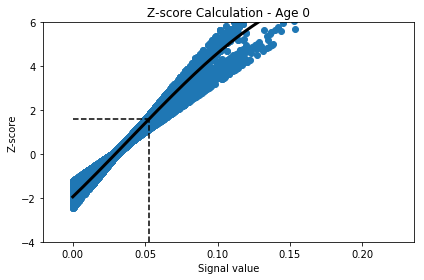

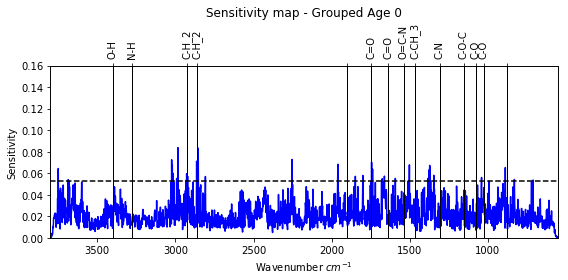

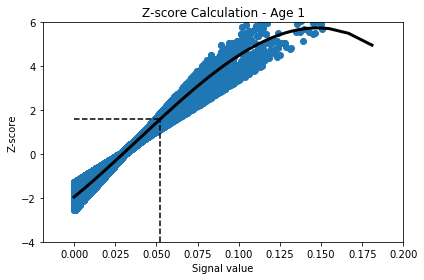

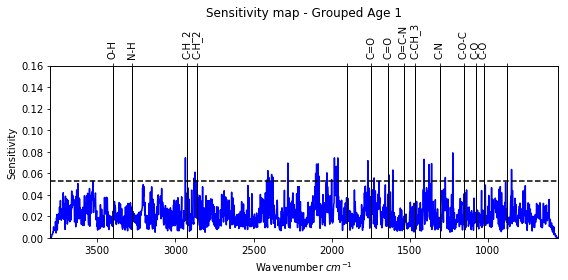

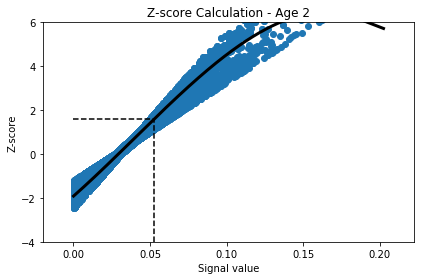

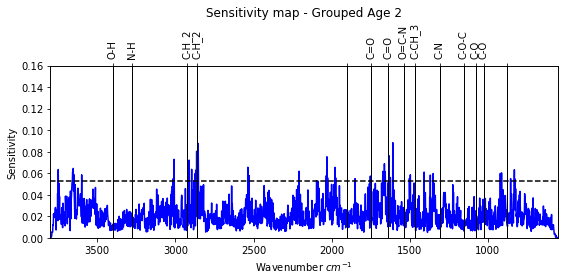

In [6]:
## Generates outputs of Z-score and sensitivty for input-ouput

outdir = "Results/"
savedir = (outdir+"Trian_Lab_Only_No_Tanzania/Sensitivity/model"+str(1)+"/")
build_folder(savedir, True)

sensitivities_save = []
for age in tqdm(range(0,3)):
    sensitivities = sensitivites_for_age(age)
    sensitivities_save.append(sensitivities)

    Z_scores = []
    m_signals = []
    for sens1 in range(10):
        for sens2 in range(10):
            s_signal = (sensitivities[sens1] + sensitivities[sens2]) / np.sqrt(2)
            mean_b = np.mean(s_signal)
            sigma_b = np.std(s_signal)
            for sig in s_signal:
                Z_b = (sig-mean_b)/sigma_b
                Z_scores.append(Z_b)
                m_signals.append(sig)

    fig = plt.figure()
    plt.scatter(m_signals, Z_scores)
    poly_index = 3
    plt.plot(np.unique(m_signals), np.poly1d(np.polyfit(m_signals, Z_scores, poly_index))(np.unique(m_signals)), color='k', linewidth=3)

    index_95 = (np.where(np.logical_and(np.poly1d(np.polyfit(m_signals, Z_scores, poly_index))(np.unique(m_signals)) < 1.7, np.poly1d(np.polyfit(m_signals, Z_scores, poly_index))(np.unique(m_signals)) > 1.6)))
    index_95 = index_95[0][int(len(index_95)/2)]

    y_value = (np.poly1d(np.polyfit(m_signals, Z_scores, poly_index))(np.unique(m_signals))[index_95])
    x_value = (np.unique(m_signals)[index_95])

    plt.plot([0, x_value], [y_value, y_value], 'k--')
    plt.plot([x_value, x_value], [-4, y_value], 'k--')
#     plt.xlim([0, 0.2])
    plt.ylim([-4, 6])
    plt.xlabel('Signal value')
    plt.ylabel('Z-score')
    plt.title(('Z-score Calculation - Age '+str(age)))
    plt.tight_layout()
    plt.savefig((savedir+'Z_Score_Grouped_Age_'+str(age)+'.png'))

    
    ## Start of individual age Sensitivity plots
#     print(sensitivities)
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,1,1)
    l1 = plt.plot(np.arange(3800, 550, -2), np.squeeze(sensitivities[0]), c='b')

    l3 = plt.plot([3800, 550], [x_value, x_value], 'k--')
    ax.set_xlim(3800, 550)
    ax.set_ylim(0, 0.16)
    ax.set_xlabel('Wavenumber $cm^{-1}$')
    ax.set_ylabel('Sensitivity')
    ax.set_title(('Sensitivity map - Grouped Age '+str(age)))

    for mol in [3400, 3276, 2923, 2859, 1901, 1746, 1636, 1539, 1467, 1307, 1154, 1076, 1027, 880]:
            l2 = plt.plot([mol, mol], [0, 0.16], 'k', linewidth=1)

#     plt.fill_between([3500, 3100], [0], [0.16], color='k', alpha=0.2)
#     plt.fill_between([2950, 2800], [0], [0.16], color='k', alpha=0.2)
#     plt.fill_between([1820, 1670], [0], [0.16], color='k', alpha=0.2)
#     plt.fill_between([1150, 1020], [0], [0.16], color='k', alpha=0.2)
#     plt.fill_between([1000, 675], [0], [0.16], color='k', alpha=0.2)

    ax2 = ax.twiny()
    new_tick_loc = [3400, 3276, 2923, 2859, 1901, 1746, 1636, 1539, 1467, 1307, 1154, 1076, 1027, 880]
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(new_tick_loc)
    ax2.set_xticklabels(['O-H', 'N-H', 'C-H_2', 'C-H_2', '', 'C=O', 'C=O', 'O=C-N', 'C-CH_3', 'C-N', 
                         'C-O-C', 'C-O', 'C-O', ''])
    plt.setp(ax2.get_xticklabels(), rotation=90)

#     custom_points = [Line2D([3800], [0], color = 'b', label='Sensitivity'),
#                      Line2D([3800], [0], color = 'k', lw=1, label='Previously used wavenumbers'),
#                      Line2D([3800], [0], color = 'k', linestyle = '--', label='95% confidence interval')]
#     ax.legend(custom_points, ['Sensitivity', 'Molecular Bands', '95% confidence interval'], loc='center left', bbox_to_anchor=(1,0.5))

    plt.tight_layout()
    plt.savefig((savedir+'Sensitivity_Map_Grouped_Age_'+str(age)+'.png'))
   